## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\peteryu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [10]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [11]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE = [10, 15, 20, 25]

In [14]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for patience in PATIENCE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()

    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    earlystop = EarlyStopping(monitor="val_loss", 
                              patience=patience, 
                              verbose=1
                              )
    
    model.fit(x_train, y_train, 
      epochs=EPOCHS, 
      batch_size=BATCH_SIZE, 
      validation_data=(x_test, y_test), 
      shuffle=True,
      callbacks=[earlystop]
     )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "patience-%d" % patience
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 3s 67us/step - loss: 1.3271 - acc: 0.5381 - val_loss: 1.5095 - val_acc: 0.4701A:
Epoch 10/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.2970 - acc: 0.5513 - val_loss: 1.4969 - val_acc: 0.4747
Epoch 11/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.2701 - acc: 0.5594 - val_loss: 1.4920 - val_acc: 0.4767
Epoch 12/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.2424 - acc: 0.5697 - val_loss: 1.4808 - val_acc: 0.4765
Epoch 13/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.2180 - acc: 0.5795 - val_loss: 1.4726 - val_acc: 0.4775
Epoch 14/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.1919 - acc: 0.5906 - val_loss: 1.4594 - val_acc: 0.4899
Epoch 15/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.1674 - acc: 0.5979 - val_loss: 1.4471 - val_acc: 0.4866
Epoch 16/50
50000/50000 [===================

50000/50000 [==============================] - 3s 67us/step - loss: 1.0083 - acc: 0.6578 - val_loss: 1.4659 - val_acc: 0.4867
Epoch 23/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.9879 - acc: 0.6653 - val_loss: 1.4719 - val_acc: 0.4914
Epoch 24/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.9671 - acc: 0.6747 - val_loss: 1.4638 - val_acc: 0.4975
Epoch 25/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9469 - acc: 0.6825 - val_loss: 1.4601 - val_acc: 0.4934
Epoch 26/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9242 - acc: 0.6897 - val_loss: 1.4708 - val_acc: 0.4960
Epoch 27/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.9048 - acc: 0.6986 - val_loss: 1.4738 - val_acc: 0.4979
Epoch 28/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.8844 - acc: 0.7077 - val_loss: 1.4830 - val_acc: 0.4936
Epoch 29/50
50000/50000 [=====================

Epoch 30/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.8649 - acc: 0.7135 - val_loss: 1.4835 - val_acc: 0.4952
Epoch 31/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.8451 - acc: 0.7208 - val_loss: 1.4846 - val_acc: 0.4982
Epoch 32/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.8256 - acc: 0.7287 - val_loss: 1.5069 - val_acc: 0.4916
Epoch 33/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.8078 - acc: 0.7366 - val_loss: 1.5134 - val_acc: 0.4898
Epoch 34/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.7902 - acc: 0.7414 - val_loss: 1.5024 - val_acc: 0.4927
Epoch 35/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.7710 - acc: 0.7511 - val_loss: 1.5100 - val_acc: 0.4951
Epoch 36/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.7511 - acc: 0.7582 - val_loss: 1.5331 - val_acc: 0.4880
Epoch 37/50
50000/50000 [=========

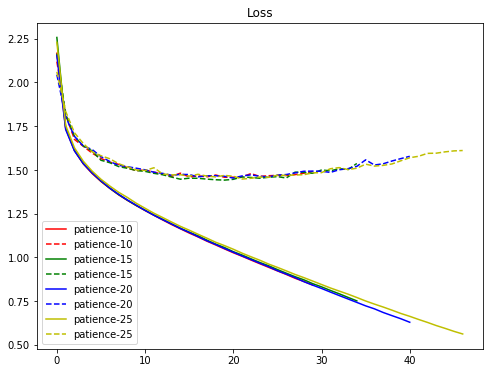

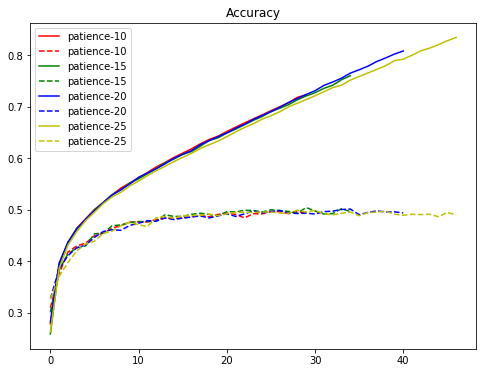

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()